Copyright (c) 2020. Cognitive Scale Inc. All rights reserved.
Licensed under CognitiveScale Example Code [License](https://github.com/CognitiveScale/cortex-certifai-examples/blob/master/LICENSE.md)


# Unordered Multiclass Classification

In this notebook we'll go through the process of building local multiclass classification models for the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) included with scikit-learn. We will then run a Certifai scan on said models to analyze Robustness, Explainability, and Performance.

This is an example of an unordered multiclass classification use case because the outcome classes (e.g. species of iris flower) are neither favorable nor unfavorable. Consequently, fairness is not applicable in this scan.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
import numpy as np
import random
import pprint

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue)
from certifai.scanner.report_utils import scores, construct_scores_dataframe

In [2]:
# Load and prepare iris dataset to train a logistic regression and svm model

RANDOM_SEED = 42
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
Y = pd.Series(iris.target, name='target')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=RANDOM_SEED)

# Train models

def build_model(data, name, model_family, test=None):
    if test is None:
        test = data
        
    def scaled_model(model):
        scaler = StandardScaler()
        return Pipeline([("scaler", scaler), (model_family, model)])
        
    if model_family == 'SVM':
        parameters = {'SVM__kernel':('linear', 'rbf', 'poly'), 'SVM__C':[0.1, .5, 1, 2, 4, 10], 'SVM__gamma':['auto']}
        m = scaled_model(SVC())
    elif model_family == 'logistic':
        parameters = {'logistic__C': (0.5, 1.0, 2.0), 'logistic__solver': ['lbfgs'], 'logistic__max_iter': [1000]}
        m = scaled_model(LogisticRegression())
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model


svm_model = build_model((X_train.values, Y_train),
                        "SVM",
                        "SVM",
                        (X_test.values, Y_test))

logistic_model = build_model((X_train.values, Y_train),
                          "logistic",
                          "logistic",
                          (X_test.values, Y_test))

Model 'SVM' accuracy is 1.0
Model 'logistic' accuracy is 1.0


In [3]:
# Wrap the model up for use by Certifai as a local model
svm_model_proxy = CertifaiPredictorWrapper(svm_model)
logistic_model_proxy = CertifaiPredictorWrapper(logistic_model)

In [4]:
# Create the scan object from scratch using the ScanBuilder class

# Below we create the prediction task, and set the `prediction_favorability` to `none` to specify that
# the outcome classes are neither favorable or unfavorable. Similarly none of the prediction outcomes
# below are marked as favorable.
unordered_task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(0, "Iris - setosa"),
        CertifaiOutcomeValue(1, "Iris - versicolor"),
        CertifaiOutcomeValue(2, "Iris - virginica")
    ],
    prediction_favorability='none'),
    prediction_description='Iris species')

scan = CertifaiScanBuilder.create("unordered_multiclass_test_use_case",
                                  prediction_task=unordered_task)

## Add models
first_model = CertifaiModel('SVM', local_predictor=svm_model_proxy)
scan.add_model(first_model)

second_model = CertifaiModel('logistic', local_predictor=logistic_model_proxy)
scan.add_model(second_model)

## Add datasets
eval_df = pd.concat([X, Y], axis=1)
eval_dataset = CertifaiDataset('evaluation', CertifaiDatasetSource.dataframe(eval_df))
scan.add_dataset(eval_dataset)
scan.evaluation_dataset_id = 'evaluation'

test_df = pd.concat([X_test, Y_test], axis=1)
test_dataset = CertifaiDataset('test', CertifaiDatasetSource.dataframe(test_df))
scan.add_dataset(test_dataset)
scan.test_dataset_id = 'test'

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'target'

## Add evaluation types
scan.add_evaluation_type('robustness')
scan.add_evaluation_type('explainability')
scan.add_evaluation_type('performance')
scan.add_metric(CertifaiModelMetric('accuracy', 'accuracy'))
scan.atx_performance_metric = 'accuracy'
print(scan.explanation_dataset_id)

None


In [5]:
# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to this notebook. This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
results = scan.run(write_reports=False)

Starting scan with model_use_case_id: 'unordered_multiclass_test_use_case' and scan_id: 'a35c4579eb3a'
[--------------------] 2023-01-05 11:09:41.419786 - 0 of 8 reports (0.0% complete) - Running robustness evaluation for model: SVM
[##------------------] 2023-01-05 11:09:59.964761 - 1 of 8 reports (12.5% complete) - Running explainability evaluation for model: SVM
[#####---------------] 2023-01-05 11:10:16.187298 - 2 of 8 reports (25.0% complete) - Running performance evaluation for model: SVM
[#######-------------] 2023-01-05 11:10:16.190701 - 3 of 8 reports (37.5% complete) - Running atx evaluation for model: SVM
[##########----------] 2023-01-05 11:10:16.192578 - 4 of 8 reports (50.0% complete) - Running robustness evaluation for model: logistic
[############--------] 2023-01-05 11:10:32.196965 - 5 of 8 reports (62.5% complete) - Running explainability evaluation for model: logistic
[###############-----] 2023-01-05 11:10:46.077791 - 6 of 8 reports (75.0% complete) - Running perfor

,context,robustness,robustness lower bound,robustness upper bound
SVM,SVM,72.205305,67.843949,76.369278
logistic,logistic,72.855424,68.721542,76.902867


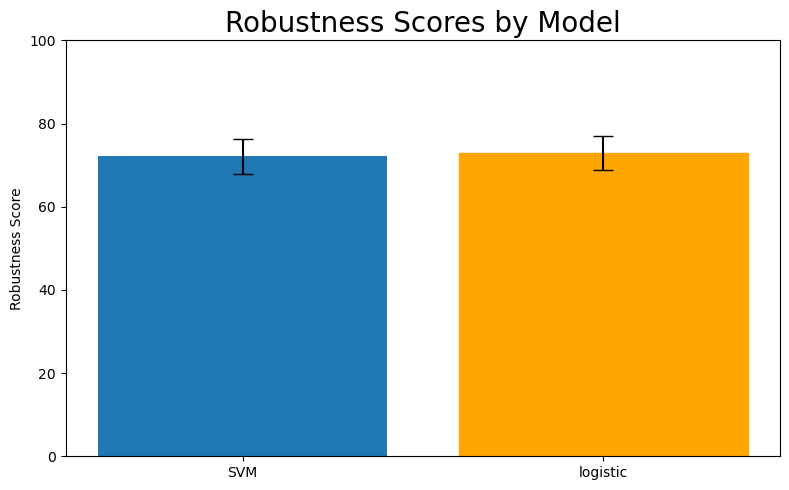

In [6]:
# Display the results of the robustness evaluation for both models
robustness_df = construct_scores_dataframe(scores("robustness", results))
display(robustness_df)

%matplotlib inline

def plot_robustness_scores():
    labels = robustness_df['context'].values
    robustness_scores = robustness_df.iloc[:, 1].values
    lower_errors = robustness_scores - robustness_df.iloc[:, 2].values
    upper_errors = robustness_df.iloc[:, 3].values - robustness_scores
    x = np.arange(len(labels))

    fig, axs = plt.subplots(figsize=[8,5])
    axs.set_title("Robustness Scores by Model", fontsize=20)
    width = 0.8

    rect1 = axs.bar(x, robustness_scores, width, yerr=[lower_errors, upper_errors], capsize=7)
    rect1[1].set_color('orange')

    axs.set_ylim(top=100)
    axs.set_ylabel('Robustness Score')
    axs.set_xticks(x)
    axs.set_xticklabels(labels)

    fig.tight_layout()
    plt.show()

plot_robustness_scores()

,context,explainability,Num features (1),Num features (10),Num features (2),Num features (3),Num features (4),Num features (5),Num features (6),Num features (7),Num features (8),Num features (9)
SVM,SVM,96.992188,75.78125,0.0,20.3125,3.90625,0.000,0.0,0.0,0.0,0.0,0.0
logistic,logistic,94.531250,71.87500,0.0,15.6250,9.37500,3.125,0.0,0.0,0.0,0.0,0.0


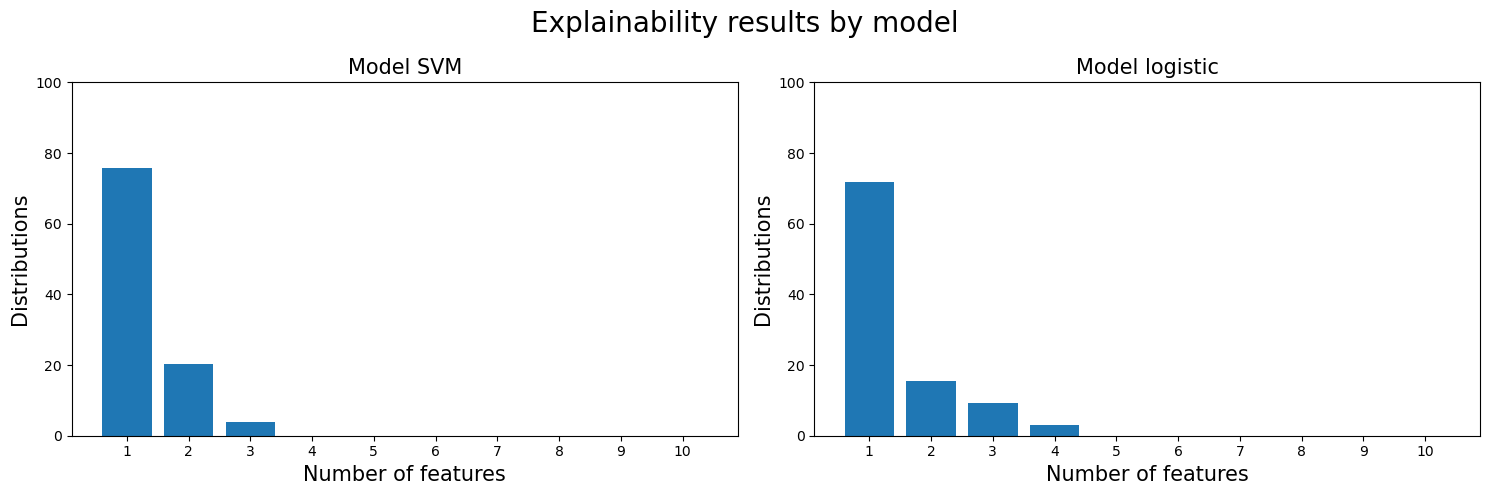

In [7]:
# Display the results of the explainability evaluation for both models
# The table displays the distributions over the number of features that must be changed to alter predictions
explainability_df = construct_scores_dataframe(scores('explainability', results))
display(explainability_df)

%matplotlib inline

def plot_histogram(axs, model_id):
    num_features = list(range(1, 11))
    columns = [f"Num features ({i})" for i in num_features]
    percentages = explainability_df.loc[model_id, columns].values
    
    axs.bar(num_features, percentages)
    axs.set_xticks(num_features)
    axs.set_xlabel('Number of features', fontsize=15)
    axs.set_title(f"Model {model_id}", fontsize=15)
    axs.set_ylabel('Distributions', fontsize=15)
    axs.set_ylim(top=100)

def plot_explainability_histograms():
    labels = explainability_df['context'].values
    
    fig, (axs1, axs2) = plt.subplots(1, 2, figsize=[15,5])
    fig.suptitle('Explainability results by model', fontsize=20)
    
    plot_histogram(axs1, labels[0])
    plot_histogram(axs2, labels[1])
    
    fig.tight_layout()
    plt.show()
    
plot_explainability_histograms()

In [8]:
# Below we will display the Accuracy value computed during the performance evaluation
print('logistic Accuracy: ', results['performance']['logistic']['performance_metrics'][0]['value'])
print('SVM Accuracy: ', results['performance']['SVM']['performance_metrics'][0]['value'])

logistic Accuracy:  1.0
SVM Accuracy:  1.0
